# Project 1 - Air Resistance in a 2D Projectile

Start by importing `numpy` for numerical computations and `matplotlib` for plotting. That should be all we need for now.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

Now we need to model our system in terms of forces acting on the projectile. Gravity is the simplest force:

$$ F_g = -mg $$

In [5]:
def gravitational_force(m, g=9.80665, dimensions=2, vertical_axis=1):
    ''' Return gravitational force on a projectile subject to gravity.
        
        Returns downward force vector in netwons. 

                  F_g = g * m  

        Args:
            
            m (np.array):           mass of the object (kg) 
            g (np.float64):         gravitational acceleration (m/s**2)
            dimensions (int):       number of dimensions in return vector
            vertical_axis (int):    axis which gravitional force acts on

        Returns:

            (np.array):             gravitational force vector (N)
    '''

    force = np.zeros(dimensions)
    force[vertical_axis] = -g * m
    
    return force

Drag force is a little more complex, it involves calculation of air resistance.

$$
    F_d = \frac{D \rho A}{2} |v|^2
$$

We will need to be able to calculated the magnitude of a multi-dimensional velocity vector, so we should create a quite helper function.

In [6]:
def magnitude(x):
    ''' Return mangitude of vector x. 

        Args:

            x (np.array):   input vector

        Returns
            
            (np.float64):   magnitude of x 
    '''

    return np.sqrt(np.sum(x * x))

The drag force is orientated in the opposite direction of the velocity vector. The easiest way to handle this geometrically is using unit vectors, hence another helper function.

In [7]:
def unit_vector(x):
    ''' Return unit vector for vector x. 

        Args:

            x (np.array):   input vector

        Returns
            
            (np.array):     unit vector for x
    '''

    return x / magnitude(x)

Now we can use these two tools to finally build our drag force function.

In [8]:
def drag_force(v, D, rho, A):
    ''' Return drag force on a projectile subject to air resistance.
        
        Returns a force vector in the opposite direction as the velocity
        vector with a magnitude determined by the drag equation below.

                    F_d = (D * rho * A) / 2 * v**2

        Args:
            
            v (np.array):       velocity vector 
            D (np.float64):     drag coefficient
            rho (np.float64):   air density (units)
            A (np.float64):     cross-sectional area (m**2)

        Returns:

            (np.array):         drag force vector 
    '''

    F_d = ((D * rho * A) / 2) * magnitude(v)**2
    
    return F_d * (-1) * unit_vector(v)

Acceleration of the projectile follows Newtons Law:

$$
    \sum F_i = ma
$$

We have already accounted for our major forces (i.e. gravity and drag), so now we just build them into a function.

In [9]:
def acceleration(x, v, A=1, D=0.5, rho=1.2, m=1):
    ''' Return the acceleration vector for a projectile subject to 
        air resistance.
        
        Uses:

                        a = F_net / m

        Args:
            
            v (np.array):       velocity vector 
            D (np.float64):     drag coefficient
            rho (np.float64):   air density (units)
            A (np.float64):     cross-sectional area (m**2)
            m (np.float64):     mass of the projectile (kg)

        Returns:

            (np.array):         acceleration vector 
    '''

    F_d = drag_force(v, D, rho, A)
    F_g = gravitational_force(m)

    return (F_d + F_g) / m

Finally, we copy over our Euler Method from GA3. We spent the time then to ensure that the function could handle multi-dimensional input. In this latest version, I built in some convient stopping conditions. The Euler Method will stop the computation once the projectile hits (x, 0) if `stop_mode='projectile'`.

The function is noticebly more complex, because we no longer know how large of an array to allocate at the start of the method. This function instead pre--allocates 128 points, and doubles the number of points everytime the algorithm reaches the end of the array.

In [43]:
def euler_method(acceleration, t0=0, tf=None, dt=0.1, x0=0, v0=0, modified=False, 
                 stop_mode='normal', vertical_axis=1, **kwargs):
    ''' Returns t, x, v, and a arrays for Euler Method

    Args:
        acceleration (func):    acceleration function **

        t0 (float):             initial time (s)
        tf (float):             final time (s)
        dt (float):             time step (s)
        
        x0 (np.array):          initial displacement (m)
        v0 (np.array):          initial velocity (m/s)
        
        stop_mode:              'normal'     run from t0 to tf
                                'projectile' run until y=0
                                
        vertical_axis           vertical axis for 'projectile' stop mode.
        
        **kwargs:               any additional parameters required for
                                    acceleration function.

    Returns:
        np.float64 (np.array):  list of times (s)
        np.float64 (np.array):  list positions (m)
        np.float64 (np.array):  list velocities (m/s)
        np.float64 (np.array):  list accelerations (m/s**2)
    '''
    
    # Allocate initial array size.
    n = 128
    t = np.empty(n)
    x = np.empty([n, 2])
    v = np.empty([n, 2])
    a = np.empty([n, 2])
        
    # Set initial conditions.
    t[0] = t0
    x[0] = x0
    v[0] = v0
    a[0] = acceleration(x0, v0, **kwargs)
    
    i = 0
    while True:
        # If array is too small, reallocate
        i += 1
        if i >= n:
            t = np.append(t, np.empty(n))
            x = np.append(x, np.empty([n, 2]), axis=0)
            v = np.append(v, np.empty([n, 2]), axis=0)
            a = np.append(a, np.empty([n, 2]), axis=0)
            
            n *= 2
        
        # Run Euler Method
        a[i] = acceleration(x[i-1], v[i-1], **kwargs)
        
        if modified:
            v[i] = v[i-1] + dt * a[i]
            x[i] = x[i-1] + dt * v[i]
        else:
            x[i] = x[i-1] + dt * v[i-1]
            v[i] = v[i-1] + dt * a[i]
            
        t[i] = t[i-1] + dt
        
        # Evaluate stopping conditions.
        if stop_mode == 'normal':
            if t[i] > tf: 
                break
        elif stop_mode == 'projectile':
            if (t[i] > t0) and x[i,vertical_axis] <= 0: 
                break

    # Truncate unused portion of arrays
    t = t[0:i+1]
    x = x[0:i+1,:]
    v = v[0:i+1,:]
    a = a[0:i+1,:]
            
    return t, x, v, a

We just need one last helper function. The initial velocity of a projectile is often specified as a velocity magnitude and an incline. The most convient form for our calculations is x, y (, and z) velocity components. They are found through some basic trigonometry.

$$ x = v_0 \cos(\phi) $$
$$ y = v_0 \sin(\phi) $$

To make thinigs unnecessarily complex, this function also handles azimuth. I am considering doing these problems in 3-dimensions so I can play with coriolis, ship velocity and bearing, and wind velocity. 

In [12]:
def launch_vector(mag, incline, azimuth=False, radians=False):
    ''' Return v0 vector for given scalar magnitude and incline above the horizon. 

        Args:
            magnitude (float):      magnitude of v0 (m/s)
            incline (float):        angle above horizon (degrees)
            azimuth (float):        angle in plane of horizon (degrees)
            radians (bool):         option for using radian incline

        Returns:
            np.array (np.float64):  vector with launch velocity components
    '''
    
    if not radians:
        incline = incline * (np.pi / 180.0)

        if azimuth:
            azimuth = azimuth * (np.pi / 180.0)
    
    if azimuth:
        z = mag * np.sin(incline)
        h = mag * np.cos(incline)

        x = h * np.cos(azimuth)
        y = h * np.sin(azimuth)

        return np.asarray([x, y, z])

    else:
        x = mag * np.cos(incline)
        y = mag * np.sin(incline)

        return np.asarray([x, y])


## Exercise 1
### 2D Projectile with Air Resistance
#### Requirements

1. Build a computational model of a 2D projectile subject to air resistance.
2. Assume air density and the drag coefficient remain constant.
3. Model inputs must be magnitude and angle of initial velocity.
4. Determine accuracy of model.
5. Determine adequate $\Delta t$ for model.
6. Plot a set of parameters of your choosing.

#### Solution

I'll start by trying out the intial velocity function.

In [13]:
launch_vector(mag=100, incline=12)

array([97.81476007, 20.79116908])

Now lets run the Modified Euler Method. We'll fire a 10 $cm^2$ shell with a drage coefficient of 0.5 at 100 $m/s$ and a $40^\circ$ incline.

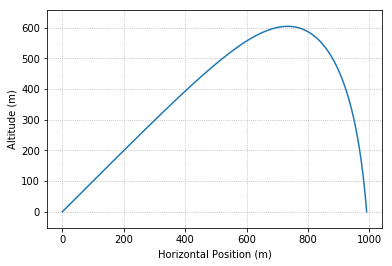

In [44]:
vi = 1000 # Initial velocity, (m/s)
inc = 45  # Inline for gun (degrees)
area = 0.01 # Cross sectional area, 10x10 cm.

dt = 0.01 # s

t, x, v, a =  fast_euler_method(acceleration, 
                           dt=dt, 
                           x0=np.asarray([0,0]), 
                           v0=launch_vector(vi, inc), 
                           modified=True, 
                           stop_mode='projectile', 
                           A=area)
    
plt.plot(x[:,0], x[:,1])
plt.grid(which='both', linestyle=':')
plt.xlabel('Horizontal Position (m)')
plt.ylabel('Altitude (m)')
plt.ylim(ymin=0)

plt.axis('equal')
plt.show()

## Exercise 2
### Shape of the 2D Projectile Trajectory
#### Requirements

1. Compare your model to a parabola, are they the same?

#### Solution

Lets create a quick helper function for plotting parabolas.

In [ ]:
def parabola(x, a, b, c):
    ''' Return a parabola given entered in standard form. '''
    
    return a * x**2 + b * x + c

Now we have to find a way to compare the modeled trajectory to that of a parabola. We will use the first few data points from the Euler method (before drag takes a significant effect) to fit the a standard parabola.

In [48]:
from scipy.optimize import curve_fit

ImportError: No module named scipy.optimize

# Exercise 3
### Angle for Maximum Projectile Range
#### Requirements

1. What angles of $\theta$ ($\pm 0.1^\circ$) maximize the range? Use three very differnt drag coefficients.
2. Plot all three trajectories together. Label max range, angle, and drag coefficient for each series.


# Exercise 4
### 2D Model with Air Resistance--Naval Gun
#### Requirements

1. Goto http://www.navweaps.com/Weapons/WNUS_1650_mk6.php and retrieve real parameters (i.e. mass, frontal area, initial velocity) for a 16" naval gun.
2. Account for changes in air density.
3. Determine a constant drag coefficient, D, by fiting your model to the following data. Use "new gun" muzzle velocities.


|**Elevation ($^\circ$)**|**AP Mark 8 (m)**|**HC Mark13 (m)**| 
|:-----:|:-----:|:-----:|
|10|16139|16642| 
|15|21854|22037| 
|20|26518|26335| 
|25|30450|29901| 
|30|33558|32918| 
|35|36119|35342| 
|40|37884|37163| 
|45|38720|38059|     

#### Solution

Lets do the easy part first: modeling altitude--dependent air density. Near the Earth (< 10,000 m), air density follows the following relasion:

$$
    \rho(y) = \rho_o \left( 1 - \frac{cy}{T_o} \right)^\alpha
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where,
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\rho_o=1.2$ is the air density at sea level ($\text{kg}/\text{m}^3$) 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$c=6.5\times10^{-3}$ is the change in temperaure with altitude ($K/m$)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$T_o=300$ is the temperature at sea level ($K$)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\alpha=2.5$ is...I have no idea...

In [45]:
def air_density(y, rho0=1.2, c=6.5e-3, T0=300, alpha=2.5):
    ''' Return altitude dependent air density, rho.

        Derrived from thermodynamic calculations and remains
        a good approximation upt to 10 km (Roos, 2018).

        Uses:

            rho(y) = rho0 (1 - (cy/T0))**alpha

        Args:

            y (float):      altitude (m)
            rho (float):    air density as sea level (kg/m**3)
            c (float):      temperature fall (K/m)
            T0 (float):     temperature at sea level (K)
            alpha (float):  unknown?

        Returns:
            
            (float):        air density at altitude (kg/m**3)
    '''

    return (rho0 * (1 - c * y / T0))**alpha

Lets fire a quick plot of that.

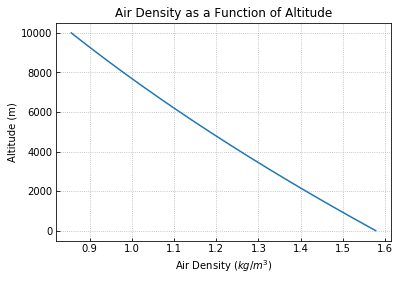

In [46]:
y = np.linspace(0, 10000, 1000)
rho = air_density(y)

plt.plot(rho, y)
plt.title('Air Density as a Function of Altitude')
plt.xlabel('Air Density ($kg/m^3$)')
plt.ylabel('Altitude (m)')

plt.grid(which='both', linestyle=':')
plt.tick_params(which='both', direction='in')

plt.show()

# Exercise 5
### Angle for Maximum Range
#### Requirements

1. Find the maximum angle for the naval projectile using the accurate paramter from Exercise 4.
2. Is the angle greater or smaller than $45^\circ$